# Step 1. Preprocessing dataset

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from scipy import stats

In [83]:
df = pd.read_csv('train.csv', header = 0)
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [84]:
# Convert 'date' column to datetime type if it's not already
df['date'] = pd.to_datetime(df['date'])

# Group by 'date' and calculate sum of 'sales' for each day
df = df.groupby('date')['sales'].sum()

print(df.head())
print(df.shape)

date
2013-01-01      2511.618999
2013-01-02    496092.417944
2013-01-03    361461.231124
2013-01-04    354459.677093
2013-01-05    477350.121229
Name: sales, dtype: float64
(1684,)


<class 'pandas.core.series.Series'>
DatetimeIndex: 1684 entries, 2013-01-01 to 2017-08-15
Series name: sales
Non-Null Count  Dtype  
--------------  -----  
1684 non-null   float64
dtypes: float64(1)
memory usage: 26.3 KB


<Axes: xlabel='date'>

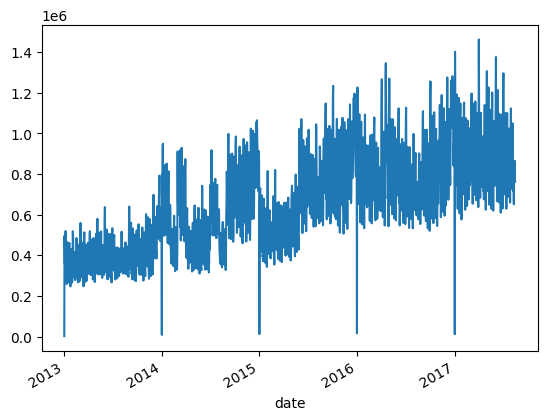

In [85]:
df.info()
df.plot()

<Axes: xlabel='date'>

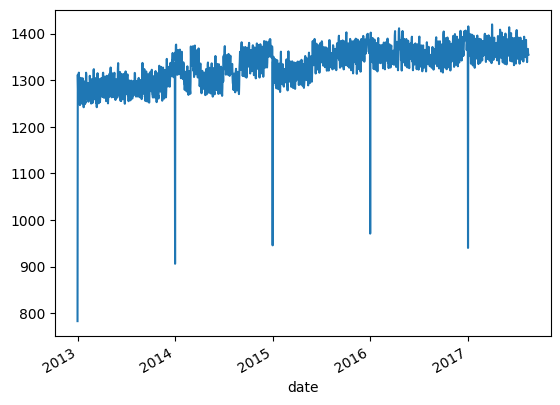

In [86]:
df = 100 * np.log(df) # don't forget to transform the data back when making real predictions
df.plot()

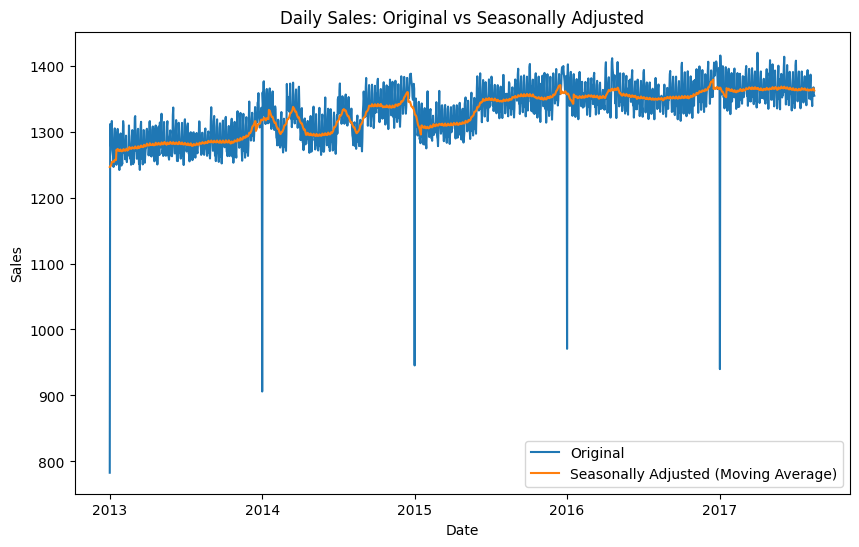

In [87]:
# Convert the index (date) to datetime if not already
df.index = pd.to_datetime(df.index)

# Calculate rolling mean (moving average) to remove seasonality
window = 30  # You can adjust the window size according to your data frequency (for daily data with weekly seasonality-7, for monthly seasonality-30)
df_sa = df.rolling(window=window, min_periods=1, center=True).mean()

# Calculate the seasonal pattern (difference between original and seasonally adjusted data)
seasonal_pattern = df - df_sa

# Plot both seasonally adjusted and unadjusted data
plt.figure(figsize=(10, 6))
plt.plot(df.index, df, label='Original')
plt.plot(df.index, df_sa, label='Seasonally Adjusted (Moving Average)')
plt.title('Daily Sales: Original vs Seasonally Adjusted')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [88]:
len(df_sa)

1684

### Splittin data in training (80%) and validating (20%) dataset 

In [89]:
# Ensure df_sa has a DateTimeIndex
df_sa.index = pd.to_datetime(df_sa.index)

# Create a mask to select all but the last 340 entries
msk = df_sa.index < df_sa.index[-340]

# Apply the mask to split the data into train and test sets
df_train = df_sa[msk].copy()
df_test = df_sa[~msk].copy()

In [90]:
df_train.head()

date
2013-01-01    1246.452497
2013-01-02    1247.742342
2013-01-03    1247.856730
2013-01-04    1248.523337
2013-01-05    1251.112871
Name: sales, dtype: float64

In [91]:
df_test.head()

date
2016-09-09    1350.271536
2016-09-10    1351.741980
2016-09-11    1353.032164
2016-09-12    1352.449669
2016-09-13    1351.186443
Name: sales, dtype: float64

In [92]:
len(df_train)

1344

In [93]:
len(df_test)

340

# Step 2. Stationarity of the Time Series Data

## Method 1. ACF and PACF

In [94]:
lag_number = 150

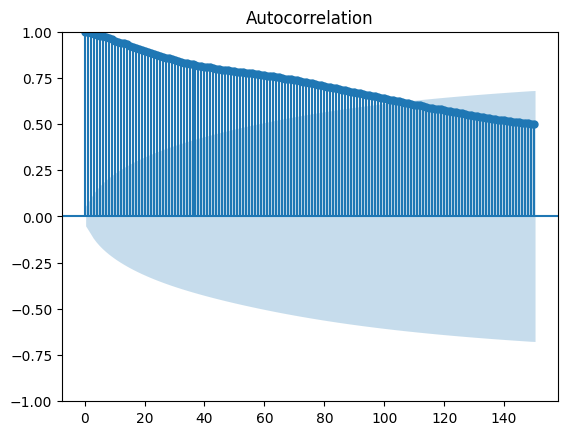

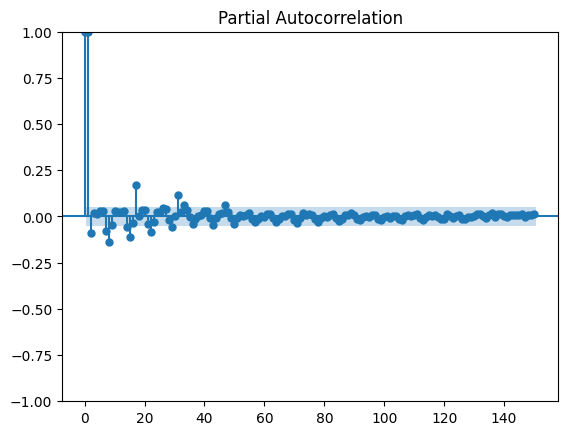

In [95]:
acf_original = plot_acf(df_train, lags=lag_number)
pacf_original = plot_pacf(df_train, lags=lag_number)

## Method 2. ADF

In [96]:
# Applying the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(df_train)

# Retrieving and displaying the test statistics and p-value
adf_statistic = adf_result[0]
p_value = adf_result[1]
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)

ADF Statistic: -2.0707675655566504
p-value: 0.25643036928705354


<Axes: xlabel='date'>

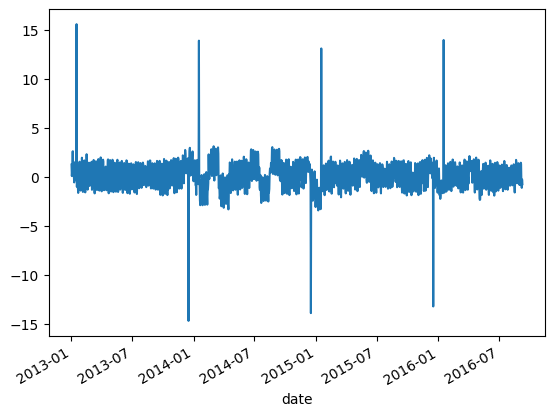

In [97]:
# Compute the first difference of the seasonally adjusted sales data
df_train_diff = df_train.diff().dropna()
df_train_diff.plot()

In [98]:
adf_test = adfuller(df_train_diff)
print(f'p-value: {adf_test[1]}')

p-value: 2.835573891320392e-09


# Step 3. Fit the model

In [99]:
stepwise_fit = auto_arima(df_train_diff, trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=4882.285, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=5005.891, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4901.650, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4880.877, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5007.197, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4882.458, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=4882.315, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4882.866, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4880.964, Time=0.04 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.980 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1343
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -2437.439
Date:                Sat, 18 May 2024   AIC                           4880.877
Time:                        22:30:18   BIC                           4896.485
Sample:                             0   HQIC                          4886.724
                               - 1343                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0774      0.054      1.435      0.151      -0.028       0.183
ma.L1          0.3216      0.011     29.408      0.000       0.300       0.343
sigma2         2.2075      0.019    118.626      0.000       2.171       2.244
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):             93801.26
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                             0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                        43.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [100]:
df_train_diff.head()

date
2013-01-02    1.289845
2013-01-03    0.114388
2013-01-04    0.666608
2013-01-05    2.589534
2013-01-06    2.651125
Name: sales, dtype: float64

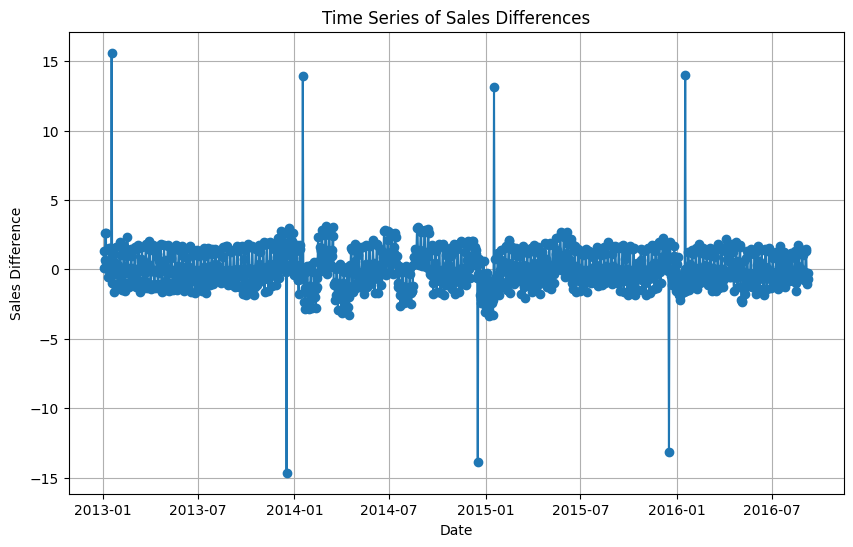

Outliers:
date
2013-01-17    15.607096
2013-12-17   -14.655093
2014-01-17    13.924636
2014-12-17   -13.862544
2015-01-17    13.130309
2015-12-17   -13.182822
2016-01-17    13.991864
Name: sales, dtype: float64


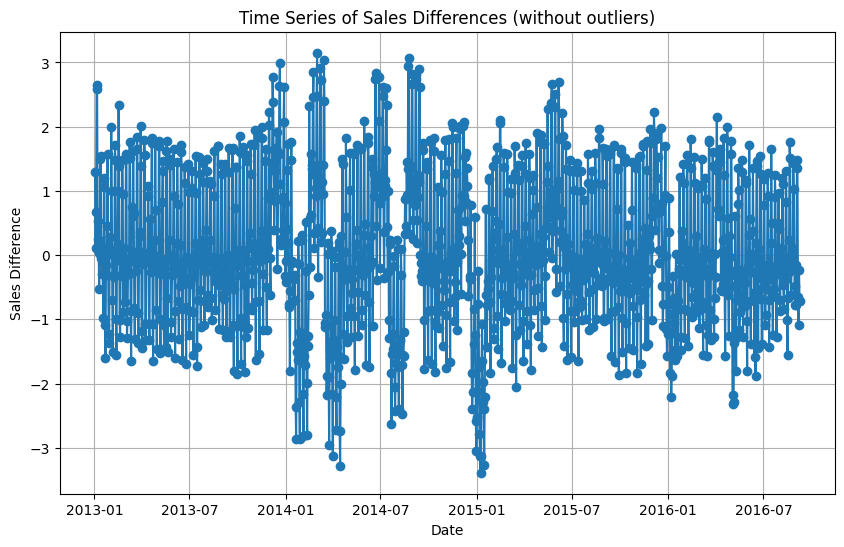

In [101]:
# Visualize the time series
plt.figure(figsize=(10, 6))
plt.plot(df_train_diff, marker='o', linestyle='-')
plt.title('Time Series of Sales Differences')
plt.xlabel('Date')
plt.ylabel('Sales Difference')
plt.grid(True)
plt.show()

# Calculate the Interquartile Range (IQR)
Q1 = df_train_diff.quantile(0.25)
Q3 = df_train_diff.quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df_train_diff[(df_train_diff < lower_bound) | (df_train_diff > upper_bound)]
print("Outliers:")
print(outliers)

# Remove outliers
df_train_diff_no_outliers = df_train_diff[~((df_train_diff < lower_bound) | (df_train_diff > upper_bound))]

# Visualize the time series without outliers
plt.figure(figsize=(10, 6))
plt.plot(df_train_diff_no_outliers, marker='o', linestyle='-')
plt.title('Time Series of Sales Differences (without outliers)')
plt.xlabel('Date')
plt.ylabel('Sales Difference')
plt.grid(True)
plt.show()

In [102]:
stepwise_fit = auto_arima(df_train_diff_no_outliers, trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3337.324, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4248.079, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3817.326, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3487.451, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4250.290, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3392.299, Time=0.47 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3431.260, Time=0.19 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=3101.363, Time=0.88 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=3390.174, Time=0.23 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=2749.250, Time=1.36 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=3331.508, Time=0.40 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=2734.634, Time=1.58 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=3349.093, Time=0.76 sec
 ARIMA(5,0,3)(0,0,0)[0] intercept   : AIC=2334.200, Time=1.63 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1336
Model:               SARIMAX(5, 0, 5)   Log Likelihood                -996.756
Date:                Sat, 18 May 2024   AIC                           2015.511
Time:                        22:30:46   BIC                           2072.683
Sample:                             0   HQIC                          2036.933
                               - 1336                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7186      0.012    142.588      0.000       1.695       1.742
ar.L2         -2.1588      0.014   -152.224      0.000      -2.187      -2.131
ar.L3          2.1128      0.020    106.721      0.000       2.074       2.152
ar.L4         -1.7072      0.014   -118.275      0.000      -1.736      -1.679
ar.L5          0.9123      0.012     75.495      0.000       0.889       0.936
ma.L1         -1.0455      0.022    -48.355      0.000      -1.088      -1.003
ma.L2          1.3123      0.027     48.688      0.000       1.259       1.365
ma.L3         -0.9450      0.034    -27.491      0.000      -1.012      -0.878
ma.L4          0.7583      0.027     28.223      0.000       0.706       0.811
ma.L5         -0.2118      0.023     -9.300      0.000      -0.256      -0.167
sigma2         0.2592      0.007     35.158      0.000       0.245       0.274
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               405.88
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -0.09
Prob(H) (two-sided):                  0.27   Kurtosis:                         5.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Check whether residuals are normally distributed or not?

C:\Users\Welcome\AppData\Local\Temp\ipykernel_6072\3366521421.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_train_diff_no_outliers, shade=True, color='blue')


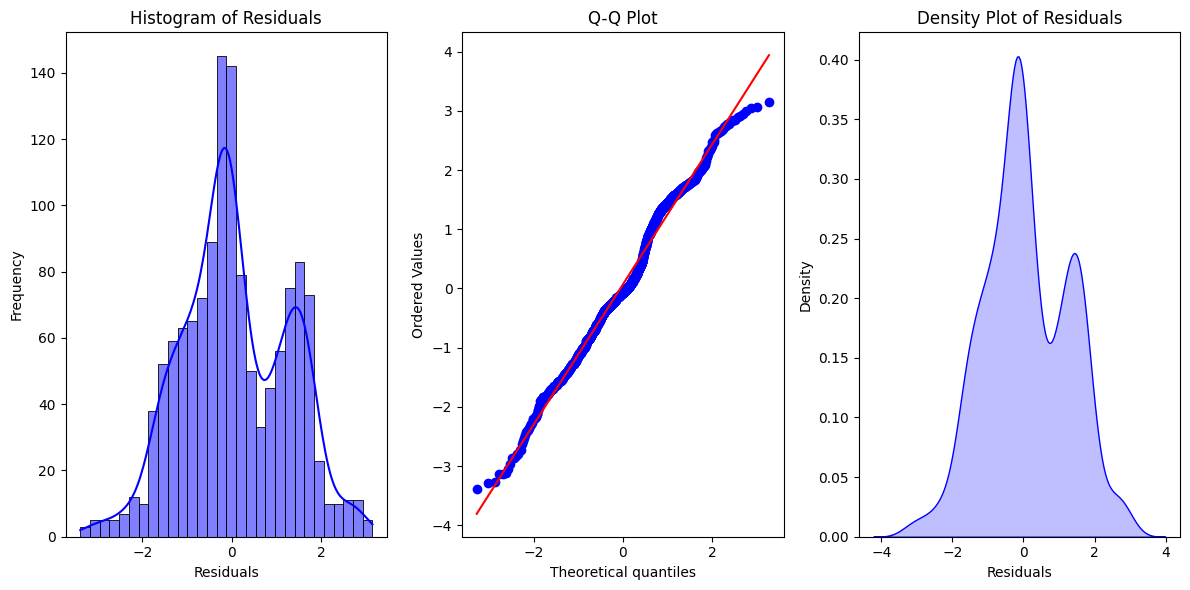

In [103]:
# Plot Histogram
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.histplot(df_train_diff_no_outliers, kde=True, color='blue', bins=30)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Plot Q-Q plot
plt.subplot(1, 3, 2)
stats.probplot(df_train_diff_no_outliers, dist="norm", plot=plt)
plt.title('Q-Q Plot')

# Plot Density Plot
plt.subplot(1, 3, 3)
sns.kdeplot(df_train_diff_no_outliers, shade=True, color='blue')
plt.title('Density Plot of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [104]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train_diff_no_outliers, order=(5,0,5))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\Welcome\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Welcome\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Welcome\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1336
Model:                 ARIMA(5, 0, 5)   Log Likelihood                -996.653
Date:                Sat, 18 May 2024   AIC                           2017.306
Time:                        22:33:07   BIC                           2079.676
Sample:                             0   HQIC                          2040.676
                               - 1336                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0685      0.099      0.688      0.491      -0.127       0.263
ar.L1          1.7168      0.012    144.137      0.000       1.693       1.740
ar.L2         -2.1588      0.014   -155.080      0.0

C:\Users\Welcome\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Step 4: Forecast

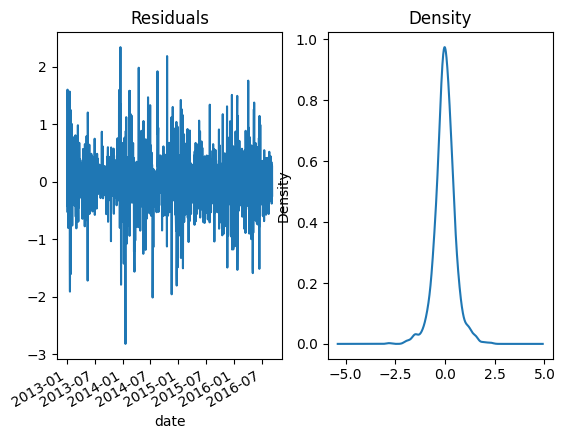

In [105]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

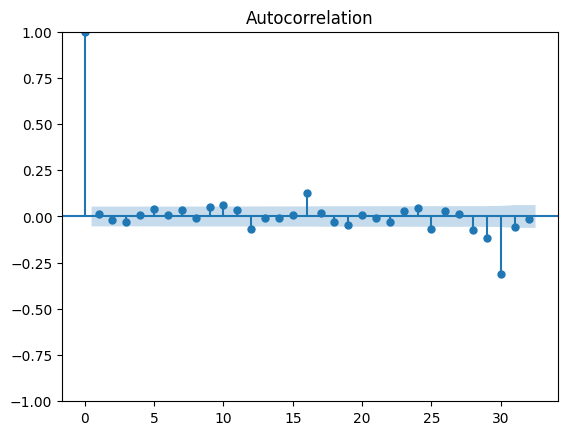

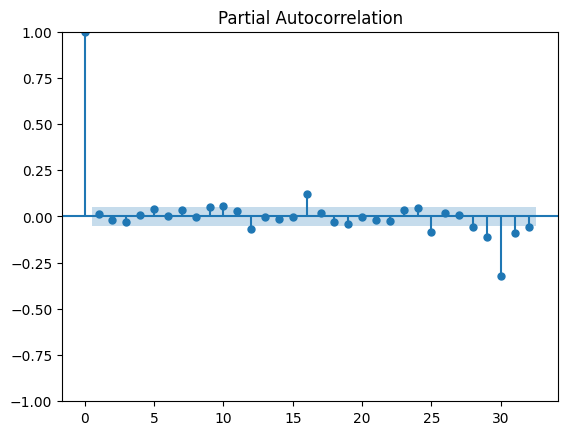

In [106]:
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

In [107]:
df_sa.head()

date
2013-01-01    1246.452497
2013-01-02    1247.742342
2013-01-03    1247.856730
2013-01-04    1248.523337
2013-01-05    1251.112871
Name: sales, dtype: float64

In [108]:
df_train.tail()

date
2016-09-04    1353.013479
2016-09-05    1352.358788
2016-09-06    1351.272151
2016-09-07    1351.040775
2016-09-08    1350.325969
Name: sales, dtype: float64

In [109]:
df_test.head()

date
2016-09-09    1350.271536
2016-09-10    1351.741980
2016-09-11    1353.032164
2016-09-12    1352.449669
2016-09-13    1351.186443
Name: sales, dtype: float64

In [110]:
df = pd.DataFrame(df_sa)
df.head()

,sales
date,
2013-01-01,1246.452497
2013-01-02,1247.742342
2013-01-03,1247.856730
2013-01-04,1248.523337
2013-01-05,1251.112871


In [111]:
df_train = pd.DataFrame(df_train)
df_train.head()

,sales
date,
2013-01-01,1246.452497
2013-01-02,1247.742342
2013-01-03,1247.856730
2013-01-04,1248.523337
2013-01-05,1251.112871


In [112]:
df_test = pd.DataFrame(df_test)
df_test.head()

,sales
date,
2016-09-09,1350.271536
2016-09-10,1351.741980
2016-09-11,1353.032164
2016-09-12,1352.449669
2016-09-13,1351.186443


In [113]:
# Forecast the differenced values
forecast_diff = model_fit.forecast(steps=len(df_test))

# Integrate the forecast back to the original scale
last_train_value = df_train['sales'].iloc[-1]
forecast_test = forecast_diff.cumsum() + last_train_value

# Add forecast values to the original df as a new column
df['forecast_manual'] = [None] * len(df_train) + list(forecast_test)

print(df)

                  sales  forecast_manual
date                                    
2013-01-01  1246.452497              NaN
2013-01-02  1247.742342              NaN
2013-01-03  1247.856730              NaN
2013-01-04  1248.523337              NaN
2013-01-05  1251.112871              NaN
...                 ...              ...
2017-08-11  1363.969842      1372.439015
2017-08-12  1365.232637      1372.488666
2017-08-13  1365.327192      1372.755980
2017-08-14  1364.185789      1372.795271
2017-08-15  1362.371251      1372.610290

[1684 rows x 2 columns]


C:\Users\Welcome\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Welcome\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


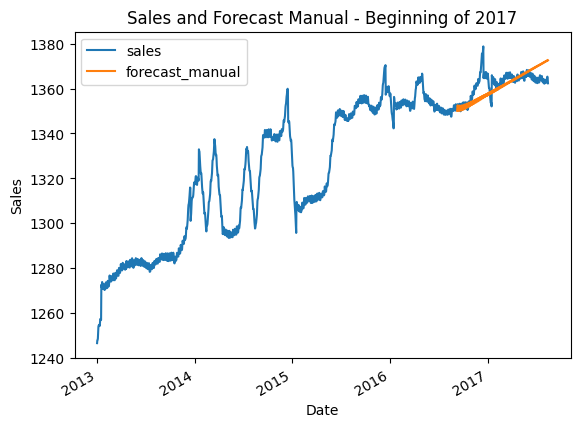

In [114]:
df[df.index >= '2013-01-01'].plot()
plt.title('Sales and Forecast Manual - Beginning of 2017')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [115]:
df_test.head()

,sales
date,
2016-09-09,1350.271536
2016-09-10,1351.741980
2016-09-11,1353.032164
2016-09-12,1352.449669
2016-09-13,1351.186443


In [116]:
forecast_test = pd.DataFrame(forecast_test)
forecast_test.head()

,predicted_mean
1336,1350.108973
1337,1351.426452
1338,1352.539899
1339,1351.917831
1340,1351.010436


In [117]:
# Extract the 'predicted_mean' column from forecast_test
forecast_values = forecast_test['predicted_mean']

In [118]:
# Reset the index of df_test['sales'] to ensure proper alignment
df_test_sales_reset_index = df_test['sales'].reset_index(drop=True)

# Align the indexes of forecast_values and df_test_sales_reset_index
forecast_values_aligned = forecast_values.iloc[:len(df_test_sales_reset_index)]

# Reset the index of forecast_values_aligned to start from 0
forecast_values_aligned.reset_index(drop=True, inplace=True)

# Calculate residuals
residuals_log = df_test_sales_reset_index - forecast_values_aligned

# Calculate MAE on the log scale
mae_log = np.mean(np.abs(residuals_log))

# Calculate MSE on the log scale
mse_log = np.mean(residuals_log**2)

# Calculate RMSE on the log scale
rmse_log = np.sqrt(mse_log)

# Calculate MAPE on the log scale
mape_log = np.mean(np.abs(residuals_log / df_test_sales_reset_index)) * 100

print("Mean Absolute Error (MAE) on log scale:", mae_log)
print("Mean Squared Error (MSE) on log scale:", mse_log)
print("Root Mean Squared Error (RMSE) on log scale:", rmse_log)
print("Mean Absolute Percentage Error (MAPE) on log scale:", mape_log)

Mean Absolute Error (MAE) on log scale: 3.9702779700030506
Mean Squared Error (MSE) on log scale: 31.600786503863514
Root Mean Squared Error (RMSE) on log scale: 5.621457684966019
Mean Absolute Percentage Error (MAPE) on log scale: 0.2908897489673513
